In [1]:
import sys
import time
import math
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
%matplotlib inline

sys.path.insert(1, '../src/')
sys.path.insert(1, '../data/')
import kde as kde
import scms as scms
from fastkde import fastKDE

In [2]:
# utility functions

def plot_2d_histogram(x, y, bins=100):
    hist, xe, ye = np.histogram2d(x,y,bins=bins)
    fig = plt.pcolormesh(xe,ye,hist.T,cmap='RdPu')
    plt.colorbar()
    plt.show()

def spiral(radius, step, resolution=.01, angle=0.0, start=0.0):
    """Spiral generator.
    Inputs:
    Radius - maximum radius of the spiral from the center.
    Defines the distance of the tail end from the center.
    Step - amount the current radius increases between each point.
    Larger = spiral expands faster
    Resolution - distance between 2 points on the curve.
    Defines amount radius rotates between each point.
    Larger = smoother curves, more points, longer time to calculate.
    Angle - starting angle the pointer starts at on the interior
    Start - starting distance the radius is from the center.
    """
    dist = start+0.0
    coords = []
    angles = []
    while dist*math.hypot(math.cos(angle),math.sin(angle))<radius:
        cord = []
        cord.append(dist*math.cos(angle))
        cord.append(dist*math.sin(angle))
        coords.append(cord)
        dist += step
        angle += resolution
        angles.append(angle)
    return coords, angles

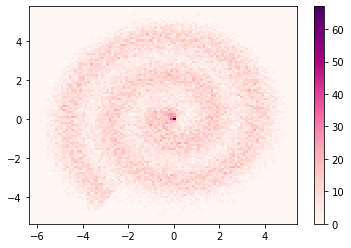

Number of Points: 48427


In [3]:
# prepare mock data

rg = np.random.default_rng()
data = rg.normal(0, 3, (10000, 2))  # a background distribution
data = data[np.where(np.linalg.norm(data, axis=1) < 5)]
cords, angles = spiral(5, 0.003)
spiral_bone = np.array(cords)
for point, angle in zip(spiral_bone, angles):
    radial_dist = rg.normal(0, 0.5, int(10 * np.linalg.norm(point)))
    if radial_dist.size == 0:
        continue
    points = np.asarray(point) + np.vstack(radial_dist) * np.asarray([math.cos(angle), math.sin(angle)])
    data = np.concatenate([data, points])
plot_2d_histogram(data[:,0], data[:,1])
print("Number of Points: {}".format(len(data)))

In [4]:
x, y = np.linspace(-7,7,129), np.linspace(-6,6,129)
xx, yy = np.meshgrid(x, y)
xy = np.array([xx.flatten(), yy.flatten()]).T

In [5]:
from sklearn.neighbors import KernelDensity
start_time = time.time()
model = KernelDensity(bandwidth=0.3, kernel='gaussian', metric='euclidean')
model.fit(data)
density = np.exp(model.score_samples(xy))
density = np.reshape(density, (129, 129), 'F')
end_time = time.time()
print("Computation time: {:.2f} seconds".format(end_time - start_time))

Computation time: 24.82 seconds


In [9]:
start_time = time.time()
pdf, axes = fastKDE.pdf(data[:,0], data[:,1], axes=[x, y])
end_time = time.time()
print("Computation Time: {:.2f} seconds".format(end_time - start_time))
pdf = pdf.swapaxes(0,1)
v1, v2 = axes

Computation Time: 0.49 seconds


In [7]:
start_time = time.time()
pdf2 = kde.kde2(data, x, y, bandwidth=0.3)
end_time = time.time()
print("Computation Time: {:.2f} seconds".format(end_time - start_time))

Computation Time: 0.01 seconds


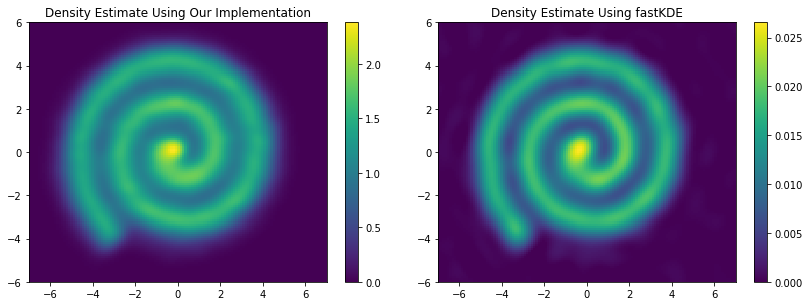

In [8]:
plt.figure(figsize=(14, 10.5))
plt.subplot(2, 2, 1)
plt.pcolormesh(x, y, pdf2.T)
plt.colorbar()
plt.title("Density Estimate Using Our Implementation")
plt.subplot(2, 2, 2)
plt.pcolormesh(v1, v2, pdf.T)
plt.colorbar()
plt.title("Density Estimate Using fastKDE")
plt.subplots_adjust(wspace=0.1)
plt.show()

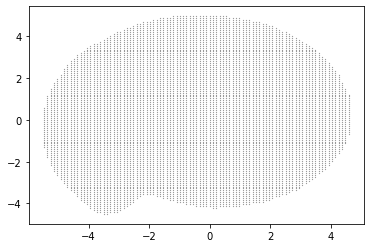

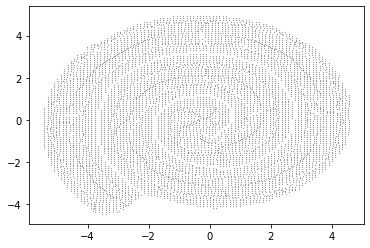

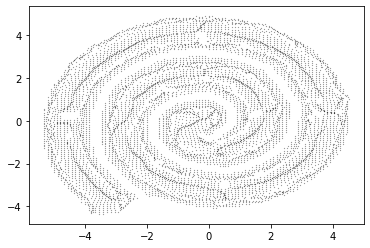

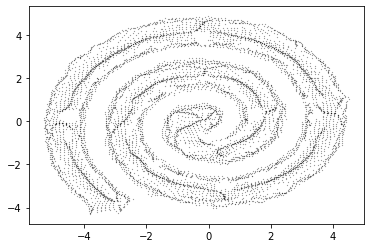

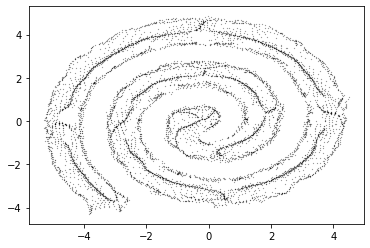

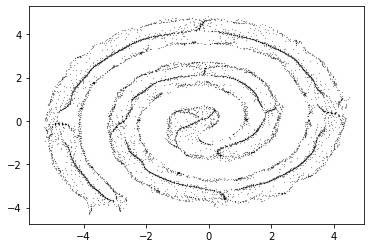

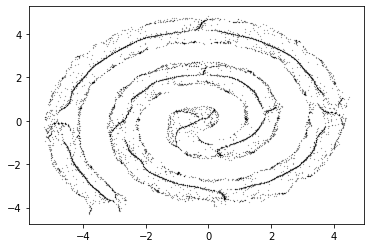

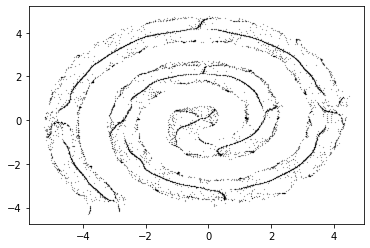

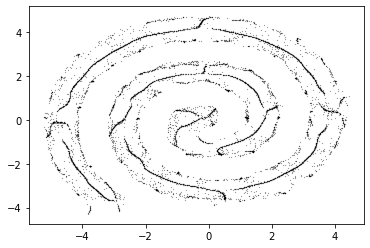

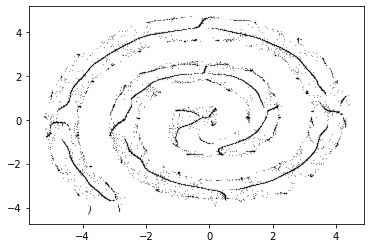

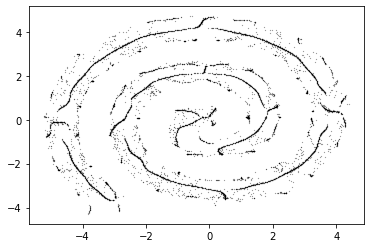

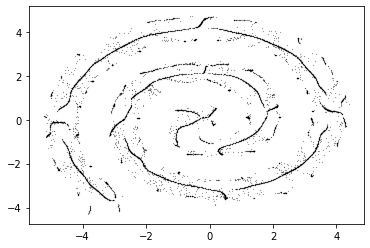

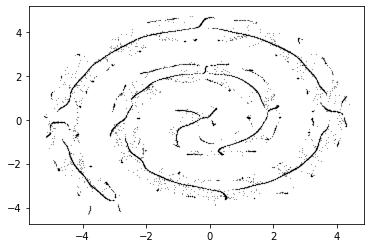

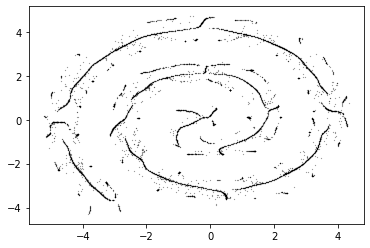

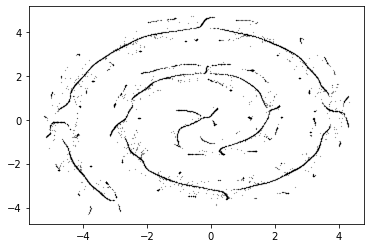

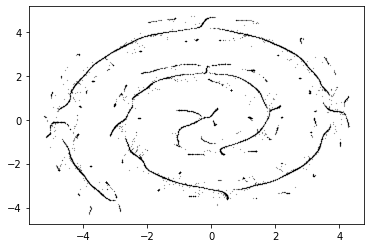

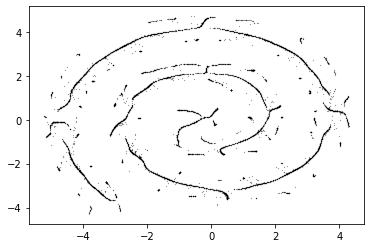

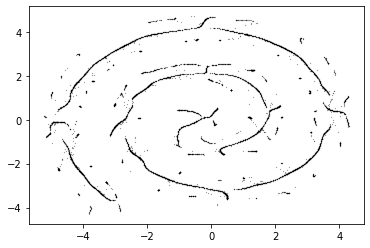

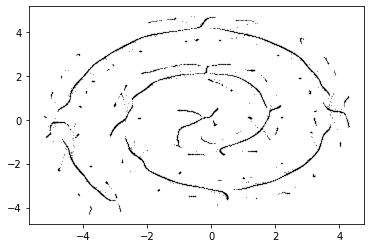

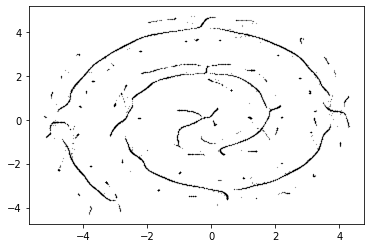

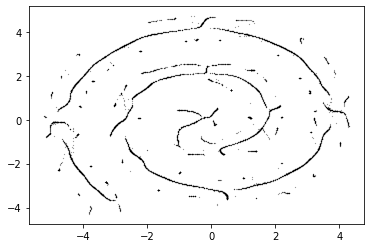

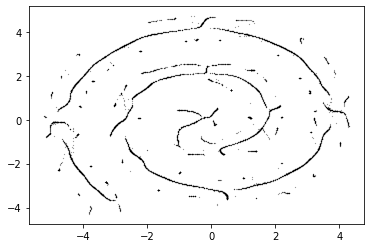

In [11]:
points = scms.generate_mesh2(x, y, 0.45, pdf2)
plt.plot(points[:,0], points[:,1], 'k.', markersize=0.3)
plt.show()
dy, dx, dyy, dxx, dxy, dyx = kde.dkde2(data, x, y, bandwidth=0.3)
dpdf = [dx, dy]
ddpdf = [dxx, dyy, dxy, dyx]
new_points = scms.scms2(points, x, y, pdf2, dpdf, ddpdf)
plt.plot(points[:,0], points[:,1], 'k.', markersize=0.3)
plt.show()

In [10]:
def NormV(vec):
    norm = np.linalg.norm(vec)
    if (norm == 0):
        return vec
    return vec/norm

#Pass in array H = [[fxx,fxy],[fyx,fyy]]/ Where these are evaluated at some
#position
#VM is a matrix that is meant to convert the MeanShift Vector
#This should be working for any number of dimensions
#Hessian- Matrix evaluated at X.
# m is number of dimensions to remove
def SpectralDecomp(Hessian,m):
    EVal, EVec = np.linalg.eigh(Hessian)
    for i in range(m):
        I = np.argmin(EVal)
        EVec = np.delete(EVec,I,0)
        EVal = np.delete(EVal,I,0)
    V = EVec
    VT = V.T
    VM = np.matmul(VT,V)
    return VM

def gradients2(points, grid_x, grid_y, bins=129, bandwidth=0.35):
#     Gx, Gy, Gxx, Gyy, Gxy, Gyx = kde.dkde2(points, grid_x, grid_y, bandwidth=0.3)
    Gy, Gx, Gyy, Gxx, Gxy, Gyx = kde.dkde2(data, x, y, bandwidth=0.3)
    return np.array(Gx), np.array(Gy), np.array([[Gxx, Gxy],[Gyx, Gyy]])

def gradients2f(f):
    #The numeric first derivatives evaluated on same grid as above
    Gx=np.gradient(f,axis = 0)
    Gy=np.gradient(f,axis = 1)
    #The second derivatives for the Hessian
    Gxx=np.gradient(Gx,axis = 0)
    Gxy=np.gradient(Gx,axis = 1)
    Gyy=np.gradient(Gy,axis = 1)
    Gyx=np.gradient(Gy,axis = 0)
    return np.array(Gx), np.array(Gy), np.array([[Gxx, Gxy],[Gyx, Gyy]])

#Bilinear interpolation
def BInterp(Xp,Yp,gx,gy,F):
    #What to do if at the very edge
    maxN = len(gx)
    if((Xp < gx[0]) or (Xp>= gx[-1])):
        #print('Out of Bounds')
        return 0
    if((Yp < gy[0]) or (Yp >= gy[-1])):
        return 0
    Nx = np.int((Xp-gx[0])/(gx[1]-gx[0]))
    Ny = np.int((Yp-gy[0])/(gy[1]-gy[0]))
    FQ11 = F[Nx,Ny]
    FQ12 = F[Nx,Ny+1]
    FQ22 = F[Nx+1,Ny+1]
    FQ21 = F[Nx+1,Ny]
    dX = gx[Nx+1]-gx[Nx]
    F1a = (gx[Nx+1]-Xp)/(dX)*FQ11
    F1b = (Xp-gx[Nx])/(dX)*FQ21
    F2a = (gx[Nx+1]-Xp)/dX*FQ12
    F2b = (Xp-gx[Nx])/dX*FQ22
    dY = gy[Ny+1]-gy[Ny]
    FI = (gy[Ny+1]-Yp)/dY*(F1a+F1b) + (Yp-gy[Ny])/dY*(F2a+F2b)
    return FI

#Apply Bi-Linear Interpolation to Hessian
def InterpHess2(zi,wi,ze,we,GHessian):
    size = np.shape(GHessian)
    dim = size[0]
    Hessian = np.zeros([dim,dim])
    for i in range(dim):
        for j in range(dim):
            Gij = GHessian[i,j,:,:]
            Gijp = BInterp(zi,wi,ze,we,Gij)
            Hessian[i,j] = Gijp
    return Hessian

#The Subspace Constrained Mean Shift Vector
def meanShift_2D(Xp,Yp,gx,gy,Gx,Gy,GH):
    Px = BInterp(Xp,Yp,gx,gy,Gx)
    Py = BInterp(Xp,Yp,gx,gy,Gy)
    MS = np.array([Px,Py])
#     MS = NormV(MS)
    #Hessian Calculations
    Hessian = InterpHess2(Xp,Yp,gx,gy,GH)
    #Change to 0? What happens
    VM = SpectralDecomp(Hessian,1)
    MC = np.matmul(VM,MS)
    MC = NormV(MC)
    return MC

#Using Cash-Karp Parameters for Embedded Runga-Kutta Method
#(Xp,Yp) - The point
#(Gx,Gy,GH) - The derivatives along each direction and the Hessian
#gx,gy - The linear grid axes for the interpolation
#dh - The step size
def RFA_EmbeddedRK_2D(Xp,Yp,Gx,Gy,GH,gx,gy,dh):
    P = [Xp,Yp]
    MC = meanShift_2D(Xp,Yp,gx,gy,Gx,Gy,GH)
    #First Step
    k1 = dh*MC
    #Step 2
    Pt = P+k1/5
    MC = meanShift_2D(Pt[0],Pt[1],gx,gy,Gx,Gy,GH)
    k2 = dh*MC
    #Step 3
    Pt = P+k1*3./40+k2*9./40
    MC = meanShift_2D(Pt[0],Pt[1],gx,gy,Gx,Gy,GH)
    k3 = dh*MC
    #Step 4
    Pt = P+k1*3./10+k2*(-9./10)+k3*6./5
    MC = meanShift_2D(Pt[0],Pt[1],gx,gy,Gx,Gy,GH)
    k4 = dh*MC
    #Step 5
    Pt = P+k1*(-11./54)+k2*5./2+k3*(-70/27)+k4*35./27
    MC = meanShift_2D(Pt[0],Pt[1],gx,gy,Gx,Gy,GH)
    k5 = dh*MC
    #Step 6
    Pt = P+k1*(1631./55296)+k2*(175./512)+k3*(575./13824)+k4*(44275./110592)+k5*(253./4096)
    MC = meanShift_2D(Pt[0],Pt[1],gx,gy,Gx,Gy,GH)
    k6 = dh*MC
    #Fifth-order Runge-Kutta formula
    Pt2 = P+k1*37/378+k3*250./621+k4*125./594+k6*512./1771
    
    #Embedded fourth-order Runge-Kutta formula
    Pt1 = P+k1*2825./27648+k3*18575./48384+k4*13525./55296+k5*277./14336+k6*1./4

    return Pt1[0],Pt1[1],Pt2[0],Pt2[1]

#f - evaluted on gx,gy grid
#dataset is any [d,n] array of points. 
def RFA_AdaptiveStep_Lin_ERK_2D(dataset,f,gx,gy,tcap):
    size = np.shape(dataset)
    Xn = ma.zeros(size[1])
    Yn = ma.zeros(size[1])
    #Each point starts with a default step size
    H = np.zeros(size[1])+0.05
    Xn = dataset[0,:]
    Yn = dataset[1,:]
    
    momentum_X = ma.zeros(size[1])
    momentum_Y = ma.zeros(size[1])
    
    #The accuracy tolerance
    dx0 = 0.000006
    dy0 = 0.000006
    #Gradient+Hessian
    Gx, Gy, GH = gradients2(data, x, y)
#     Gx, Gy, GH = gradients2f(f)
    #Iterate through, SCMS algorithm
    for t in range(tcap):
        for i in range(size[1]):
            Xp = Xn[i]
            Yp = Yn[i]
            if(ma.is_masked(Xp) or ma.is_masked(Yp)):
                continue
            if(abs(Xp) >= 100.):
                continue
            if(abs(Yp) >= 100):
                continue
            h = H[i] #Each point has its own error
            #Embedded Runge-Kutta
            x1,y1,x2,y2 = RFA_EmbeddedRK_2D(Xp,Yp,Gx,Gy,GH,gx,gy,h)
            dx1 = abs(x2-x1)
            modx = 2 if dx1 == 0 else min((dx0/dx1)**0.2, 2)
            dy1 = abs(y2-y1)
            mody = 2 if dy1 == 0 else min((dy0/dy1)**0.2, 2)
            mod = min(modx, mody)
            if(mod < 1): #d1 > d0, we have to retry! with new step
                h = h*mod
                x1,y1,x2,y2 = RFA_EmbeddedRK_2D(Xp,Yp,Gx,Gy,GH,gx,gy,h)
                H[i] = h #update the new h value
                x_temp, y_temp = Xn[i], Yn[i]
                Xn[i] = x2 + momentum_X[i] * 1
                Yn[i] = y2 + momentum_Y[i] * 1
                momentum_X[i] = x2 - x_temp
                momentum_Y[i] = y2 - y_temp
            else: #We can safely increase the next step size
                H[i] = h*mod
                x_temp, y_temp = Xn[i], Yn[i]
                Xn[i] = x2 + momentum_X[i] * 0
                Yn[i] = y2 + momentum_Y[i] * 0
                momentum_X[i] = x2 - x_temp
                momentum_Y[i] = y2 - y_temp
        plt.plot(Xn,Yn,'k.',markersize=0.3)
        plt.show()
    return Xn,Yn,H

In [ ]:
from numpy import ma
v1,v2 = x, y
zg,wg = np.meshgrid(v1,v2,indexing='ij')
zg_ma = ma.masked_where(pdf2 < 0.45, zg)
zg = None
wg_ma = ma.masked_where(pdf2 < 0.45, wg)
wg = None
T = zg_ma.compressed()
newS = len(T)
P1_ma = ma.zeros((2,newS))
P1_ma[0,:] = zg_ma.compressed()
P1_ma[1,:] = wg_ma.compressed()
%time X1,Y1,H1 = RFA_AdaptiveStep_Lin_ERK_2D(P1_ma,pdf2,v1,v2,20)
plt.plot(X1,Y1,'k.',markersize=0.3)
plt.show()